# Time Series Forecasting using ARIMA

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# Imports

import numpy as np
import pandas as pd
import pandas.util.testing as tm
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('dark_background')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  """


In [3]:
data = pd.read_csv('/content/gdrive/MyDrive/AirPassengers.csv')

In [4]:
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [5]:
data = data.rename(columns={'#Passengers': 'Passengers'})

In [6]:
data.isnull().sum()

Month         0
Passengers    0
dtype: int64

In [7]:
data.dtypes

Month         object
Passengers     int64
dtype: object

In [8]:
data.shape

(144, 2)

In [9]:
data["Month"] = pd.to_datetime(data['Month'])
data.dtypes

Month         datetime64[ns]
Passengers             int64
dtype: object

In [10]:
data.set_index("Month",inplace = True)

### EDA

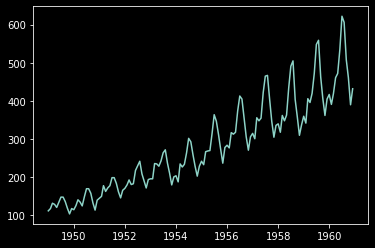

In [11]:
plt.plot(data['Passengers'])

Here, Data doesn't look stationary. To check whether data is stationary or not, we use Augmented Dickey fuller test. ( An augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample),p value(0<=p<=1) should be as low as possible for it to be stationary.

In [12]:
from statsmodels.tsa.stattools import adfuller
x = data.iloc[:,0].values   # accepts only 1d array of time series
result = adfuller(x)
print(" P val -> ", result[1])  # has the p value

 P val ->  0.9918802434376409


p val close to one, hence it is not stationary!

In [13]:
data['year'] = [d.year for d in data.index]
data['month'] = [d.strftime('%b') for d in data.index]
years = data['year'].unique()

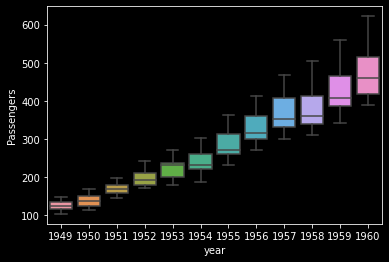

In [14]:
sns.boxplot(x='year', y='Passengers', data=data)

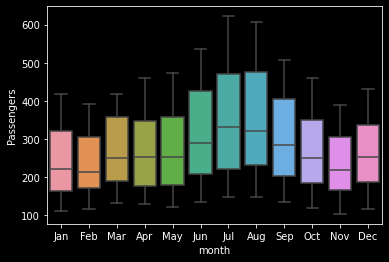

In [15]:
sns.boxplot(x='month', y='Passengers', data=data)

Decomposition provides a useful abstract model for thinking about time series generally and for better understanding problems during time series analysis and forecasting.



*   Level: The average value in the series.
*   Trend: The increasing or decreasing value in the series.
*   Seasonality: The repeating short-term cycle in the series.
*   Noise: The random variation in the series (Non -systematic componenet that cannot be modeled)



In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose 
decomposed = seasonal_decompose(data['Passengers'],  model ='additive') # y(t) = Level + Trend + Seasonality + Noise (additive model)

In [17]:
trend = decomposed.trend
seasonal = decomposed.seasonal 
residual = decomposed.resid

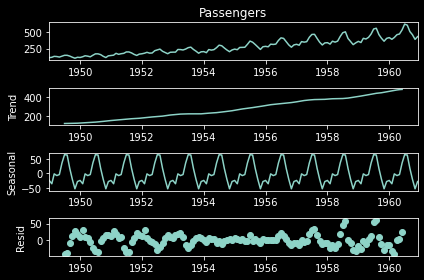

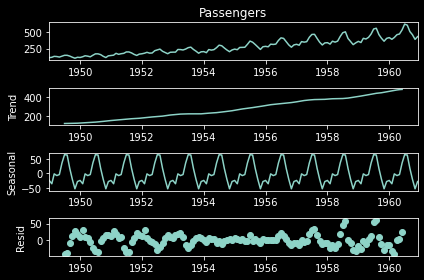

In [18]:
decomposed.plot()

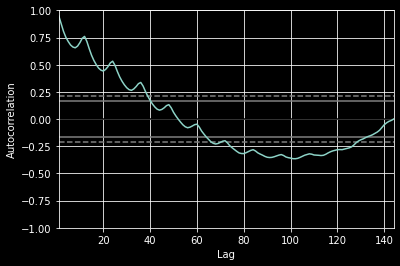

In [19]:
from pandas.plotting import autocorrelation_plot  # the correlation of a series with its own lags.
autocorrelation_plot(data.Passengers) 

-> Any data less than 40 months is positively correlated.



## Using ARIMA

Auto_arima provide the best model (e.g. SARIMA) and it's parameters.Auto arima suggests best model and parameters based on AIC metric (relative quality of statistical models)

*  p - number of autoregressive terms (AR)
*  q - Number of moving avergae terms (MA)
*  d - number of non-seasonal differences
*  p, d, q represent non-seasonal components
*  P, D, Q represent seasonal components

In [21]:
from pmdarima.arima import auto_arima
arima_model = auto_arima(data['Passengers'], start_p = 1, d=1, start_q = 1, 
                          max_p = 5, max_q = 5, max_d=5, m = 12, 
                          start_P = 0, D=1, start_Q=0, max_P=5, max_D=5, max_Q=5,
                          seasonal = True, 
                          trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True,  
                          stepwise = True, n_fits=50)   

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1022.393, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.23 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.19 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1020.393, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1019.239, Time=0.35 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=1020.582, Time=0.78 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.67 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1020.493, Time=0.43 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=5.51 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1032.120, Time=0.24 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1021.120, Time=0.48 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1021.032, Time=0.66 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1019.178, Time=0.39 sec
 ARIMA(0,1,1)(1,1,0)[12]     

In [22]:
print(arima_model.summary() )

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -505.589
Date:                             Mon, 14 Jun 2021   AIC                           1019.178
Time:                                     14:11:42   BIC                           1030.679
Sample:                                          0   HQIC                          1023.851
                                             - 144                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3634      0.074     -4.945      0.000      -0.508      -0.219
ar.S.L12      -0.1239      

### Model to be used : SARIMAX (0,1,1)* (2,1,[],12)

In [25]:
df = data[["month","Passengers"]]

In [26]:
size = int(len(df) * 0.66)
X_train, X_test = df[0:size], df[size:len(df)]

In [27]:
X_train.shape,X_test.shape

((95, 2), (49, 2))

In [29]:
from statsmodels.tsa.statespace.sarimax import SARIMAX 
  
model = SARIMAX(X_train['Passengers'],order = (0, 1, 1),seasonal_order =(2, 1, 1, 12)) 
  
res = model.fit() 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [30]:
res.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         Passengers   No. Observations:                   95
Model:             SARIMAX(0, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -300.269
Date:                            Mon, 14 Jun 2021   AIC                            610.538
Time:                                    14:19:40   BIC                            622.572
Sample:                                01-01-1949   HQIC                           615.369
                                     - 11-01-1956                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3206      0.102     -3.155      0.002      -0.520      -0.121
ar.S.L12       0.6847      0.650      1.053      0.292      -0.589       1.959
ar.S.L24       0.3140      0.132      2.387      0.017       0.056       0.572
ma.S.L12      -0.9797      5.426     -0.181      0.857     -11.615       9.655
sigma2        78.6966    375.923      0.209      0.834    -658.099     815.492
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.56
Prob(Q):                              0.95   Prob(JB):                         0.28
Heteroskedasticity (H):               1.69   Skew:                             0.42
Prob(H) (two-sided):                  0.18   Kurtosis:                         2.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
ytr_pred = res.predict(0, len(X_train)-1) 

In [35]:
yte_pred = res.predict(len(X_train), len(df)-1)

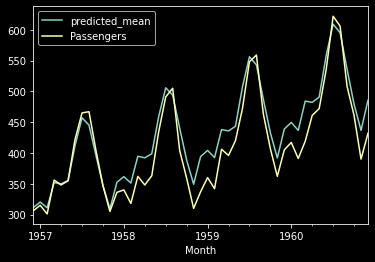

In [38]:
yte_pred.plot(legend = True) 
X_test['Passengers'].plot(legend = True) 

In [39]:
import math
from sklearn.metrics import mean_squared_error

In [44]:
ytr_pred.values

array([  0.        , 111.99829717, 117.99981751, 131.99957431,
       129.00009121, 121.00024325, 134.99957432, 147.99960471,
       147.99999999, 136.00036487, 119.00051691, 104.00077398,
       174.00139236, 121.00353289, 138.54734047, 137.22134547,
       127.71157753, 139.86886565, 159.07286935, 166.49731197,
       156.87734677, 140.64031077, 120.44937887, 130.06635054,
       134.12169015, 151.68904688, 165.35321782, 168.50734379,
       155.13847798, 188.72853381, 200.94579794, 199.62371763,
       187.19982862, 161.51893297, 143.59225105, 168.98896645,
       170.2295036 , 177.48697778, 205.30698372, 182.89027543,
       187.30144423, 194.78034964, 232.81147625, 230.90120638,
       223.91440054, 190.05403842, 173.5971427 , 195.33876403,
       200.47454045, 205.30440034, 217.10788888, 215.40013739,
       235.08097041, 258.91685217, 262.79290537, 273.46947799,
       242.15199705, 219.38820593, 195.2174207 , 207.07708355,
       206.38625482, 206.79098517, 228.55927174, 228.49

In [46]:
rmse_train = math.sqrt(mean_squared_error(X_train["Passengers"], ytr_pred.values))
rmse_test = math.sqrt(mean_squared_error(X_test['Passengers'],yte_pred.values))

In [47]:
rmse_train,rmse_test

(16.14281887632033, 29.48310441995827)

In [49]:
forecast = res.predict(start = len(df),  end = (len(df)-1) + 2 * 12,  typ = 'levels').rename('Forecast')

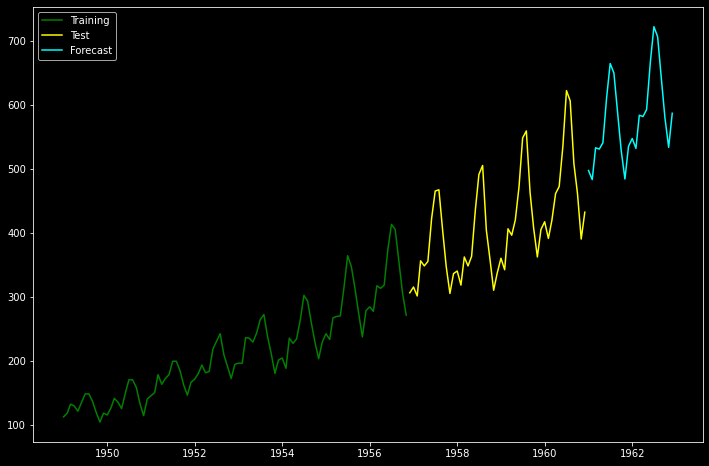

In [55]:
plt.figure(figsize=(12,8))
plt.plot(X_train['Passengers'], label='Training', color='green')
plt.plot(X_test['Passengers'], label='Test', color='yellow')
plt.plot(forecast, label='Forecast', color='cyan')
plt.legend(loc='upper left')
plt.show()